In [1]:
import tensorflow as tf
import os
import numpy as np  
import pandas as pd  

from skimage.io import imread
from skimage.morphology import label

ship_dir = "../data/"
train_image_dir = os.path.join(ship_dir, "train_v2")

2023-06-27 13:00:51.568886: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 13:00:54.574825: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 13:00:54.578582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 13:01:04.184312: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def multi_rle_encode(img):
    """
    Encode connected regions as separated masks
    """
    labels = label(img[:, :, 0])
    return [rle_encode(labels == k) for k in np.unique(labels[labels > 0])]


# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    """
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    """
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype=np.float32)
    # if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [7]:
masks = pd.read_csv(os.path.join(ship_dir, "segmentation_v2.csv"))
masks.head(10)

,ImageId,EncodedPixels
0,0001124c7.jpg,NaN
1,000303d4d.jpg,NaN
2,000d26c17.jpg,NaN
3,0011c31b7.jpg,NaN
4,00160335a.jpg,NaN
5,00167446e.jpg,NaN
6,0016ae695.jpg,NaN
7,001739657.jpg,NaN
8,00189cc36.jpg,NaN
9,001eda01f.jpg,368419 8 369187 8 369955 8 370723 8 371491 8 3...


In [8]:
#creating dataframe with extended details about images (if it has ship and how many)
masks["ships"] = masks["EncodedPixels"].map(
    lambda c_row: 1 if isinstance(c_row, str) else 0
)
unique_img_ids = masks.groupby("ImageId").agg({"ships": "sum"}).reset_index()
unique_img_ids["has_ship"] = unique_img_ids["ships"].map(
    lambda x: 1.0 if x > 0 else 0.0
)

masks.drop(["ships"], axis=1, inplace=True)
unique_img_ids.sample(5)

,ImageId,ships,has_ship
5589,786b72a92.jpg,0,0.0
6447,8ad577303.jpg,0,0.0
5648,79b9e2092.jpg,0,0.0
9525,ccdbbbf10.jpg,0,0.0
9638,cf90845d2.jpg,0,0.0


<Axes: >

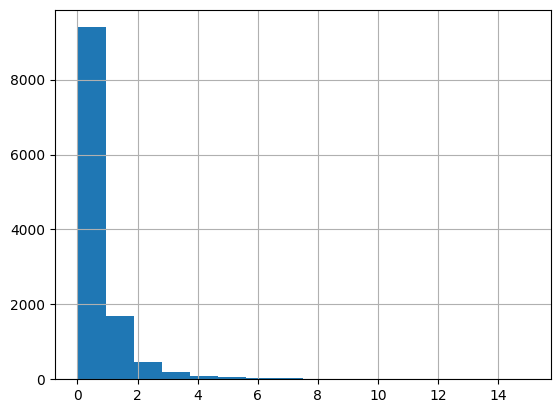

In [9]:
#Here we examine how often ships appear
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max()+1)

450 masks


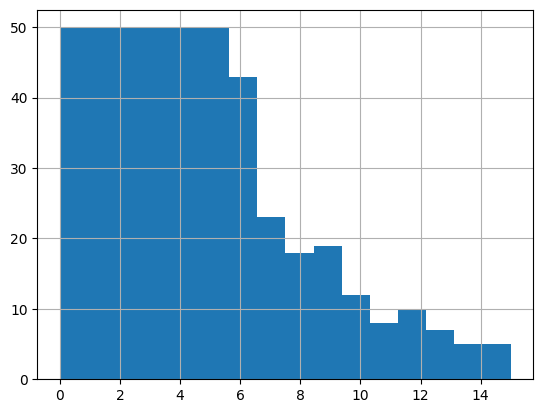

In [10]:
# Here we undersample the empty images to get a better balanced group with more ships to try and segment
SAMPLES_PER_GROUP = 50
balanced_train_df = unique_img_ids.groupby("ships").apply(
    lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x
)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [11]:
# Split into training and validation groups
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')
train_df.head()

1680 training masks
418 validation masks


,ImageId,EncodedPixels,ships,has_ship
0,0011c31b7.jpg,NaN,0,0.0
1,008d2170e.jpg,514596 23 515341 46 516109 46 516877 46 517645...,6,1.0
2,008d2170e.jpg,271381 1 272148 3 272915 6 273683 7 274450 9 2...,6,1.0
3,008d2170e.jpg,208996 2 209760 7 210525 10 211291 13 212057 1...,6,1.0
4,008d2170e.jpg,201267 1 202033 4 202800 6 203567 7 204336 7 2...,6,1.0


In [12]:
# Decode all the RLEs into Images
# We make a generator to produce images
def make_image_gen(in_df, batch_size=1):
    all_batches = list(in_df.groupby("ImageId"))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks["EncodedPixels"].values)
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0) / 255.0, np.stack(out_mask, 0)
                out_rgb, out_mask = [], []


# training data generator
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)

# validation data generator
val_gen = make_image_gen(valid_df, 20)
valid_x, valid_y = next(val_gen)

In [13]:
# Augment data
from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(
    featurewise_center=False,
    samplewise_center=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="reflect",
    data_format="channels_last",
)

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator(**dg_args)


def create_aug_gen(in_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(
            255 * in_x, batch_size=in_x.shape[0], seed=seed, shuffle=True
        )
        g_y = label_gen.flow(in_y, batch_size=in_x.shape[0], seed=seed, shuffle=True)

        yield next(g_x) / 255.0, next(g_y)


cur_gen = create_aug_gen(train_gen)

t_x, t_y = next(cur_gen)

In [14]:
# Build the model
inputs = tf.keras.layers.Input(t_x.shape[1:])

# Contraction path
c1 = tf.keras.layers.Conv2D(
    16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(
    16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(
    32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(
    32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(
    64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(
    64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(
    128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(
    128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(
    256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(
    256, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(
    128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(
    128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(
    64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(
    64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(
    32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(
    32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding="same")(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(
    16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(
    16, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
)(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()


2023-06-27 13:10:52.020222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-27 13:10:52.052711: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 768, 768, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [15]:
#making custom loss and score functions
import keras.backend as K
from keras.losses import binary_crossentropy

##Dice coefficient
def dice_coef(y_true, y_pred, smooth=0.0001):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2.0 * intersection + smooth) / (union + smooth), axis=0)


def dice_p_bce(in_gt, in_pred):
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

#compile model
model.compile(optimizer="adam", loss=dice_p_bce, metrics=[dice_coef, "binary_accuracy"])


In [16]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_dice_coef"),
    tf.keras.callbacks.ModelCheckpoint(
        "seg_model.h5", verbose=1, save_best_only=True
    ),
]

history = model.fit(
    cur_gen,
    batch_size=16,
    validation_data=(valid_x, valid_y),
    steps_per_epoch=10,
    epochs=10,
    callbacks=callbacks,
)

Epoch 1/20


2023-06-27 13:15:01.293191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-27 13:15:06.540539: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.
2023-06-27 13:15:06.540593: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.
2023-06-27 13:15:06.765373: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2023-06-27 13:15:06.767503: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2023-06-27 13:15:08.844759: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 1

10/10 [==============================] - ETA: 0s - loss: -0.0092 - dice_coef: 0.0099 - binary_accuracy: 0.5171

In [ ]:
def show_loss(loss_history):
    epoch = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 10))
    _ = ax1.plot(epoch,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epoch, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epoch, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epoch, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('Binary Accuracy (%)')
    
    _ = ax3.plot(epoch, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epoch, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('DICE')
    
show_loss([history])   